Assignment Trip Planner:
    
AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input
  |
search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation
  |
search weather forcasting
1. get current weather
2. get weather forcast
  |
search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range
  |
calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
    | 
currency_converion
1. get exchnage rate
2. convert currancy
    | 
Itinery generation
1. get day plan
2. crete full itinery
    |
create Trip Summary
    |
Retun complete traval plan

Note: if you know the OOPS then design this entire system using object and class in modular fashion.


deadline is till next friday 9PM IST


 everyone you can submit the assignments in this form. MAke sure to have one GitHub link and put all the assignments there https://forms.gle/g8RZ4qx8yvNcih4B7    
    


In [1]:


from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from datetime import date,datetime


class TravelState(BaseModel):
    # ✅ User Input
    city: Optional[str] = None
    start_date: Optional[date] = None
    end_date: Optional[date] = None
    currency: Optional[str] = "INR"
    budget_per_day: Optional[float] = None
    num_people: Optional[int] = 1
    interests: List[str] = Field(default_factory=list)

    # ✅ Attractions, Restaurants, Activities
    attractions: List[Dict] = Field(default_factory=list)
    restaurants: List[Dict] = Field(default_factory=list)
    
    activities: List[Dict] = Field(default_factory=list)
    transport: List[Dict] = Field(default_factory=list)

    # ✅ Weather
    weather_current: Optional[Dict] = None
    weather_forecast: Dict[str, Dict] = Field(default_factory=dict)

    # ✅ Hotel & Budget
    hotel_options: List[Dict] = Field(default_factory=list)
    selected_hotel: Optional[Dict] = None
    hotel_cost_total: Optional[float] = None

    # ✅ Cost Breakdown
    total_cost_local: Optional[float] = None
    total_cost_converted: Optional[float] = None
    daily_budget_converted: Optional[float] = None

    # ✅ Currency Conversion
    exchange_rate: Optional[float] = None

    # ✅ Itinerary & Summary
    itinerary: Dict[str, List[Dict]] = Field(default_factory=dict)
    trip_summary: Optional[str] = None

    # Support params
    geo_location:Optional[Dict[str,float]] = None


def get_user_input(state: TravelState) -> TravelState:
    print("✈️  Let's plan your trip!\n")

    # In a real app this data would come from chat UI or form
    city = input("Enter destination city: ")
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    currency = input("Enter your preferred currency (e.g., USD, INR, EUR): ")
    budget = float(input("Enter your daily budget (in your currency): "))
    people = int(input("How many people are travelling? "))
    interests = input("What are your travel interests? (comma separated): ")

    # Update state
    state.city = city.strip()
    state.start_date = datetime.strptime(start_date.strip(), "%Y-%m-%d").date()
    state.end_date = datetime.strptime(end_date.strip(), "%Y-%m-%d").date()
    state.budget_per_day = budget
    state.currency = currency.strip().upper()
    state.num_people = people
    state.interests = [i.strip().lower() for i in interests.split(",") if i.strip()]

    return state


In [2]:
import os
import requests
from dotenv import load_dotenv

load_dotenv()

GEOAPIFY_API_KEY = os.getenv("GEOAPIFY_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
AMADEUS_CLIENT_ID = os.getenv("AMADEUS_CLIENT_ID")
AMADEUS_CLIENT_SECRET = os.getenv("AMADEUS_CLIENT_SECRET")


def get_city_coordinates(state:TravelState) -> TravelState:
    geo_url = "https://api.geoapify.com/v1/geocode/search"
    geo_params = {
        "text": state.city,
        "format": "json",
        "apiKey": GEOAPIFY_API_KEY
    }

    geo_resp = requests.get(geo_url, params=geo_params).json()

    if not geo_resp['results']:
        raise ValueError("City not found")

    lat = geo_resp['results'][0]['lat']
    lon = geo_resp['results'][0]['lon']

    state.geo_location = {'lat':lat,'lon':lon}
    
    return state

def search_attractions(state: TravelState) -> TravelState:
    print(f"\n🔍 Searching for attractions in {state.city} based on your interests...\n")

    
    lat = state.geo_location['lat'] # geo_resp['results'][0]['lat']
    lon = state.geo_location['lon'] # geo_resp['results'][0]['lon']

    poi_url = "https://api.geoapify.com/v2/places"

    poi_params = {
        "categories": "tourism.sights,entertainment,leisure,heritage",
        "filter": f"circle:{float(lon)},{float(lat)},5000",  # within 5km
        "limit": 10,
        "apiKey": GEOAPIFY_API_KEY
    }

    poi_resp = requests.get(poi_url, params=poi_params).json()
    features = poi_resp.get("features", [])

    attractions = []
    for f in features:
        props = f["properties"]
        attractions.append({
            "name": props.get("name"),
            "type": props.get("categories", []),
            "lat": f["geometry"]["coordinates"][1],
            "lon": f["geometry"]["coordinates"][0],
            "duration_hr": 1.5,  # default estimate
            "cost": 0,  # you can combine with Viator API later
            "slot": "morning" if "museum" in props.get("categories", []) else "afternoon"
        })

    state.attractions = attractions
    print(f"✅ Fetched {len(attractions)} real attractions for {state.city}")

    return state



In [3]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def get_llm(model_name = 'gemini-1.5-flash'):
    from langchain_google_genai import ChatGoogleGenerativeAI
    try:
        model=ChatGoogleGenerativeAI(model=model_name)
        print('llm created')
        return model
    except Exception as e:
        message = f"Could not load model {model_name}. Error: {e}"
        
        print(message)
        return None

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def generate_itinerary(state: TravelState) -> TravelState:
    print(f"\n🤖 Generating itinerary via LLM for {state.city}...\n")

    # Build a single string question from the state
    question = f"""
        Trip Details:
        City: {state.city}
        Dates: {state.start_date.strftime('%Y-%m-%d')} to {state.end_date.strftime('%Y-%m-%d')}
        People: {state.num_people}
        Daily Budget: {state.budget_per_day} {state.currency}
        Hotel: Mention appropriate hotel and cost per night
        Transport: Mention transportation cost per person

        Attractions:
        {chr(10).join(f"- {a['name']}" for a in state.attractions)}

        """

    template = """
        You are an expert trip advisor. Based on the trip details provided, generate a clear, day-by-day detaileditinerary and a simple cost breakdown. 
        Only return the itinerary and cost summary text. 
        Trip Details:
        {question}
        {format_instructions}
        """

    prompt = PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": StrOutputParser()}
    )

    model = get_llm()

    chain = prompt | model | StrOutputParser()

    response = chain.invoke({"question": question.strip()})

    state.itinerary = response
    state.trip_summary = response

    print("Parsed response:", response)
    return state


In [7]:
from langgraph.graph import StateGraph, START, END

# Initialize graph with state type (use a Pydantic class or dict for state)
workflow = StateGraph(TravelState)

workflow.add_node("get_user_input", get_user_input)
workflow.set_entry_point("get_user_input")

workflow.add_node("get_city_coordinates", get_city_coordinates)
workflow.add_node("search_attractions", search_attractions)
# workflow.add_node("search_activities", search_activities)
# workflow.add_node("search_hotels", search_hotels)
workflow.add_node("generate_itinerary",generate_itinerary)

workflow.add_edge(START,"get_user_input")
workflow.add_edge("get_user_input","get_city_coordinates")
workflow.add_edge("get_city_coordinates","search_attractions")
# workflow.add_edge("search_attractions","search_activities")
workflow.add_edge("search_attractions","generate_itinerary")
workflow.add_edge("generate_itinerary",END)

app = workflow.compile()

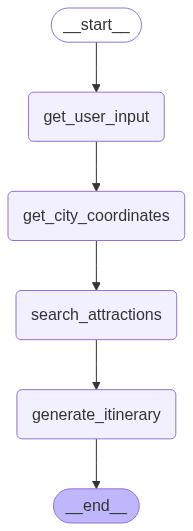

In [8]:
app

In [9]:
app.invoke(TravelState())

✈️  Let's plan your trip!


🔍 Searching for attractions in paris based on your interests...

✅ Fetched 10 real attractions for paris

🤖 Generating itinerary via LLM for paris...

llm created
Parsed response: **Paris Itinerary: December 1st, 2025 - December 12th, 2025 (27 People)**

**Hotel:**  Given the large group size (27 people), securing a single hotel may be challenging.  Consider booking several rooms across two or three large hotels near central Paris (e.g.,  Novotel Paris Les Halles, Hotel Saint-André des Arts, Pullman Paris Tour Eiffel).  Assume an average cost of €200 per night per room for a double occupancy, requiring approximately 14 rooms. This will need to be confirmed based on availability during the specified dates.

**Transportation:**  For a group of 27, private coach transport will be the most efficient.  Assume a daily cost of €500 for the coach (this needs confirmation based on specific routes and distances). Individual metro/bus tickets will be less efficient for

d:\anaconda-install\envs\aiagent\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, list[dict[any, any]]]` - serialized value may not be as expected [input_value="**Paris Itinerary: Decem...enhance the experience.", input_type=str])
  return self.__pydantic_serializer__.to_python(


{'city': 'paris',
 'start_date': datetime.date(2025, 12, 1),
 'end_date': datetime.date(2025, 12, 12),
 'currency': 'EUR',
 'budget_per_day': 120.0,
 'num_people': 27,
 'interests': ['siteseeing'],
 'attractions': [{'name': 'Église Saint-Eustache',
   'type': ['building',
    'building.historic',
    'building.place_of_worship',
    'heritage',
    'religion',
    'religion.place_of_worship',
    'religion.place_of_worship.christianity'],
   'lat': 48.8633996997262,
   'lon': 2.3451275528571394,
   'duration_hr': 1.5,
   'cost': 0,
   'slot': 'afternoon'},
  {'name': 'Église Saint-Étienne-du-Mont',
   'type': ['building',
    'building.historic',
    'building.place_of_worship',
    'heritage',
    'religion',
    'religion.place_of_worship',
    'religion.place_of_worship.christianity'],
   'lat': 48.84654669973038,
   'lon': 2.348016990862071,
   'duration_hr': 1.5,
   'cost': 0,
   'slot': 'afternoon'},
  {'name': "Fondation Cartier pour l'art contemporain",
   'type': ['building',
